## Introduction

The first step in any analysis is to review the data that will be analyzed. Large datasets typically contain missing data, data errors (e.g. due to an error during measurement or data entry), or entries that violate statistical assumptions (so-called outliers). 

To put that another way, during data review you need to assess whether the data need to be cleaned *before* analysis (e.g. review the metadata, including the collection date, mass, or other covarites), and whether the data follow traditional statistical assumptions, including normality.

In this notebook, we will review data preprocessing steps that are common in bioinformatics. To do so, we will use the statistical computing environment *R*.

### Download the test data

To practice data preprocessing techniques, let's use [publicly available](http://www.pnas.org/content/112/13/4032) glucosinolate data. The formatted data can be downloaded here:

curl https://raw.githubusercontent.com/timeu/gwas-lecture/master/data/cmeyer_glucs2015/bmeyer_etal.txt --create-dirs --output data/cmeyer_glucs2015/bmeyer_etal.txt

### Check the file format

Before importing data, it is always important to review the file format. Is it a text file? Is it an hdf5 file? Does to need to be transposed?

- If it is a text file:
  - What delimiter was used to make the file? 
  - What character set was used?   (see the command *iconv*)
  - What carriage return was used? (see the command *dos2unix*)
  - Are there spaces or unexpected characters in the header? (see vim/emacs)
  - Are there quotes or comment characters that will interrupt the import?

- If it is an hdf5 file:
  - What are the keys?
  
### Load the glucosinolate data

In [1]:
# rm(list=ls());
# open the glucosinolate file in R

glucosinolateFileName <- "data/cmeyer_glucs2015/bmeyer_etal.txt";  
glucs <- read.table(glucosinolateFileName, header=T, sep="\t", as.is=T, stringsAsFactors=FALSE);  
glucs <- glucs[order(glucs[,"accession_id"]),];

In [2]:
# what's in the working environment?
ls(); 

[1] "glucosinolateFileName" "glucs"

In [3]:
# nb: this is a working R environment
# to learn the syntax of an argument, use the question mark followed by the command line
# ?head

In [4]:
# str(glucs);

In [5]:
head(glucs);

,accession_id,sample_weight,G2P,G3B,G3HP,G4P,G2H3B,G4HB,G2H4P,G3MTP,⋯,G6MTH,G5MSP,G7MTH,G6MSH,G8MTO,G7MSH,G3BOP,G8MSO,G4BOB,G5BOP
892,1,27.0,1391.3143,103708.84,35.89132,5248.4694,25310.19,0.000000,656.2984,0,⋯,3611.0269,32.32934,2951.46171,96.03157,8243.8638,2142.1924,0.00000,23523.238,1424.3284,0.00000
1692,1,22.1,7734.5149,69932.37,0.00000,2500.7568,24289.34,0.000000,390.3385,0,⋯,116.8998,56.07342,0.00000,247.84098,0.0000,1401.4957,67.66343,27462.923,1789.0852,920.67350
683,2,15.2,8267.7205,144750.06,202.10448,5545.6431,78817.75,7.136438,1966.7867,0,⋯,411.9168,76.65779,0.00000,1016.59783,0.0000,11407.0228,0.00000,102816.760,8169.7092,3357.24848
870,2,29.9,1411.4871,27739.70,0.00000,116.5999,24817.58,0.000000,435.3465,0,⋯,2256.3011,0.00000,46.88039,0.00000,577.0562,389.6314,0.00000,7644.041,284.5212,0.00000
887,2,31.0,1055.4795,82117.61,88.72688,2589.5366,29056.36,32.245193,1213.7386,0,⋯,8806.8255,227.51344,3107.01884,428.95742,18943.1403,2913.7202,0.00000,36178.023,2610.6636,61.77065
973,2,30.9,967.1328,38721.42,0.00000,880.6843,17378.24,34.532081,391.1320,0,⋯,2292.2790,0.00000,810.27345,93.65825,2614.6889,970.8893,0.00000,9763.230,493.1664,0.00000


In [6]:
# it's important to run sanity checks to ensure that you have loaded the entire dataset
dim(glucs); # returns the dimensionality in row x column format
nrow(glucs); # returns the number of rows
ncol(glucs); # returns the number of columns

# when you begin to write scripts, add comments so that 
# future readers (such as yourself) know what you were doing
# the comment character in R is #

[1] 2199   24

[1] 2199

[1] 24

In [7]:
# R functions are often 'silent' (return from a function invisibly)
# In addition, the numbers above lack context. The two commands
# cat and print can be used to add user feedback. As an example:
cat("There are: ", nrow(glucs), " rows and ", sep="");
cat( ncol(glucs), " columns in the dataset.\n", sep="");
cat("There are:", length(which(is.na(glucs))), "missing data (i.e. NAs).\n");

# the newline character is '\n' 

There are: 2199 rows and 24 columns in the dataset.
There are: 0 missing data (i.e. NAs).


### Quality control in *nix?
If the numbers do not match your expectation, open the file in vi/emacs or another text editor... and look for special characters or quotes/comments that may have interrupted the import.

You're probably familiar with some of the more common errors. For example, if the number of columns doesn't match the number of column names, *R* will return an error. However, this is a 'nice' error, because it forces you to look at the data in more detail. The scariest errors are the errors that escape your attention. It's thus very important to review your data (e.g. what happens if you concatenate 2 data files?).

In [8]:
# or alternatively:
# command <- paste0( "head ", glucosinolateFileName );
# print( system( command, wait=T, intern=T ));

### What is the phenotype?

The glucosinolate data were generated with the plant genetic model species *Arabidopsis thaliana*

One of the main reasons geneticists use *A. thaliana* is because it is self compatible, which means that inbred lines can be created through self pollination. In *A. thaliana*, these inbred lines were created by placing each plant's flowers in bags to minimize cross pollination among individuals.

The seeds from these inbred lines can then be used as replicates in experiments. Replicated inbred lines allow us to estimate the mean phenotype for any given genotype at a much higher precision level than is usually possible in obligate outcrossing species. For GWAS, work with inbred lines improves power - since one can use *fewer* individuals than would be necessary in other species.

But how many replicates are available for each line? And how should we handle these replicates?

In [9]:
cat("There are:", length(unique(glucs$accession_id)), "unique accessions.\n");
tableOfAccessionIds <- table(glucs$accession_id);
tableOfAccessionIds;

There are: 595 unique accessions.



     1      2      4      6      7      8      9     12     23     32     45 
     2      4      3      4      4      4      4      3      3      5      4 
    51     60     62     66     69     74     79     80     81     83     84 
     3      2      5      7      6      3      5      3      4      2      5 
    85     86     87     88     89     91     94     96    104    106    116 
     4      3      4      5      3      5      3      6      6      2      2 
   121    122    126    137    146    148    149    151    153    157    159 
     5      4      6      4      2      3      3      4      3      3      3 
   160    163    165    166    167    169    170    173    174    175    178 
     2      4      6      5      5      2      2      2      4      3      6 
   179    183    184    185    187    188    190    191    194    196    198 
     2      6      3      5      4      4      3      4      6      4      5 
   200    202    203    204    205    206    207    208    210 

In [10]:
# That's hard to read, somewhat better is:
rangeOfReplicates <- range(tableOfAccessionIds);
cat("The number of replicates ranges between ", rangeOfReplicates[1], " and ", rangeOfReplicates[2], "\n", sep="");
cat("With a mean of:", mean(tableOfAccessionIds), "\n");

# if lme4, ggplot2, and gridExtra aren't installed, install them...
if( !require("lme4" )){  
    install.packages("lme4");  
}

if( !require("ggplot2" )){  
    install.packages("ggplot2");  
}

if( !require("gridExtra" )){  
    install.packages("gridExtra");  
}


The number of replicates ranges between 2 and 8
With a mean of: 3.695798 


Loading required package: lme4
Warning message:
“package ‘lme4’ was built under R version 3.4.4”Loading required package: Matrix
Loading required package: ggplot2
Loading required package: gridExtra


Don't know how to automatically pick scale for object of type table. Defaulting to continuous.


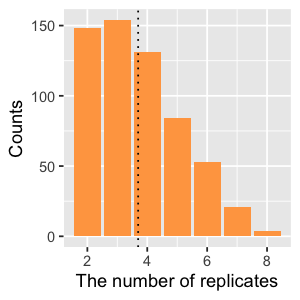

In [11]:
# there's quite a range of replicate counts
# plot the # of replicates per genotype
options(repr.plot.width=2.5, repr.plot.height=2.5)
counts <- table(glucs$accession_id);
ggplot() + aes(counts) + 
        xlab( paste0( "The number of replicates" )) + ylab("Counts") +
        geom_bar(stat="count", fill="tan1") + 
        geom_vline(aes(xintercept=mean(counts)), linetype=3);

### Estimate the mean phenotype per genotype

In [12]:
# tapply offers a fast way to estimate the mean (or any other summary statistic) across a factor
dataSummary <- stack(with(glucs, tapply(G2P, list(accession_id), mean))); # stack can be used to convert a vector into a 2-col matrix
colnames(dataSummary) <- c("tapply_mean", "accession_id" );
tail(dataSummary);

,tapply_mean,accession_id
590,11339.72940,9482
591,66.02516,9490
592,130.62605,9496
593,594.60669,9499
594,116.24258,9504
595,792.81981,100000


<!-- # this is roughly equivalent to using something more model-based
# residuals are often used in GWAS, especially when nuisance variables are taken 'into account' (e.g. plate_id, etc.)
# as a simple example:
lm0 <- lm( G2P ~ 1, data=glucs); 
resids <- stack(residuals(lm0));-->

In [13]:
# another option: use a mixed model to specify a random effect
require(lme4);
lmer0 <- lmer( G2P ~ 1 + (1|accession_id), data=glucs );
blups <- ranef(lmer0)$accession_id; # these are the best-linear unbiased predictors:
blups <- data.frame( accession_id=rownames(blups), blup=blups[,1], stringsAsFactors=FALSE );
head(blups);

accession_id,blup
1,-5271.448
2,-8390.965
4,-8618.790
6,-9610.424
7,-7955.538
8,-9497.424


accession_id,blup,tapply_mean
1,-5271.4476,4562.9146
100000,-10511.2044,792.8198
1026,-8858.4554,102.3605
104,-9552.1414,3157.4517
106,-5942.3350,2967.9322
1061,-523.5105,16211.3113


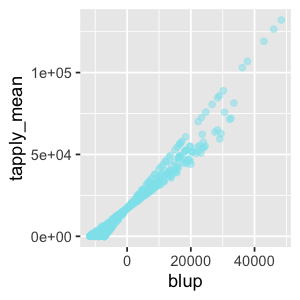

In [14]:
both <- merge(blups, dataSummary, by="accession_id" );
head(both);
ggplot( both, aes(x=blup, y=tapply_mean)) + geom_point(alpha=0.5, col="cadetblue2" ); 

The two techniques are similar, but the results aren't perfectly correlated. Why? (one approach: identify the outlier accessions)

### Checking model assumptions/normality for a phenotype

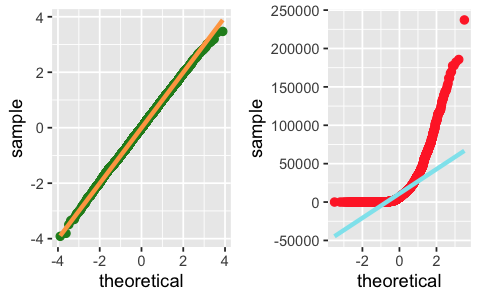

In [15]:
# count data are often non-normal, there are various ways 
# to investigate normality, including Normal Q-Q plots (quantile-quantile) plots
# here is an example with data sampled from a normal distribution:
normalData <- rnorm(1e4);
p1 <- ggplot() + aes(sample=normalData) + stat_qq(col="forestgreen", size=2) + stat_qq_line(col="tan1", size=1.25);

# and the glucosinolate G2P
p2 <- ggplot( glucs, aes(sample=G2P)) + stat_qq(col="firebrick1", size=2) + stat_qq_line(col="cadetblue2", size=1.25);

options(repr.plot.width=4, repr.plot.height=2.5)
grid.arrange(p1, p2, ncol = 2);

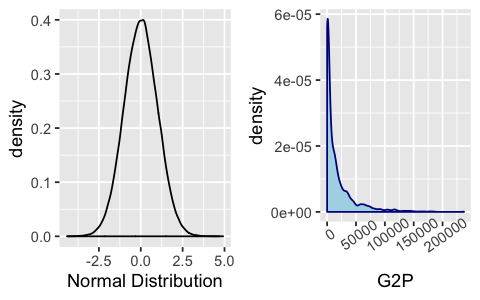

In [16]:
# The Q-Q plot suggests the data are highly non-normal
# The non-normality is also evident in a density plot:
p1 <- ggplot() + aes(x=rnorm(1e5)) + 
            xlab( "Normal Distribution") +
            geom_density();
p2 <- ggplot( glucs, aes(x=G2P)) + 
            theme(axis.text.x = element_text(angle = 35)) +
            geom_density(color="darkblue", fill="lightblue");

grid.arrange(p1, p2, ncol = 2);

In [17]:
# Again, the data are clearly non-normal. These are visual tests, which are fine,
# but you may want to use formalized tests such as the Shapiro-Wilk test:
shapiro.test(glucs$G2P);


	Shapiro-Wilk normality test

data:  glucs$G2P
W = 0.66011, p-value < 2.2e-16


In [18]:
# or the Kolmogorov-Smirnov (KS) normality test:
# nb: y can either be a vector of data values or a character string naming a cumulative distribution function (cdf)
ks.test( glucs$G2P, y="pnorm"); 

Warning message in ks.test(glucs$G2P, y = "pnorm"):
“ties should not be present for the Kolmogorov-Smirnov test”


	One-sample Kolmogorov-Smirnov test

data:  glucs$G2P
D = 0.86539, p-value < 2.2e-16
alternative hypothesis: two-sided


### The data are clearly non-normal!!!

What are your other options? In the next notebook, we'll consider some alternative approaches.
